In [1]:
!pip install torch torchvision torchaudio
!pip install umap-learn scikit-learn matplotlib seaborn
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.linear_model import LogisticRegression

import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.io import arff
import pandas as pd

from tslearn.datasets import UCR_UEA_datasets

In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [14]:
# Carrega com tslearn
ucr = UCR_UEA_datasets()
X, y, _, _ = ucr.load_dataset("ECG5000")  # X: (n_amostras, 140, 1)

# Remove última dimensão e normaliza
X = X.squeeze()  # (n_amostras, 140)
X = StandardScaler().fit_transform(X)

# Divisão com poucos rótulos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, stratify=y, random_state=SEED
)

# Generate t-SNE embeddings for the test set
tsne = TSNE(n_components=2, random_state=SEED)
X_proj = tsne.fit_transform(X_test_embed[:1000])  # Use subset for efficiency
labels_proj = y_test[:1000].astype(int)  # Ensure labels are integers

In [13]:
class TimeSeriesDatasetCPC(Dataset):
    def __init__(self, data, segment_length=30, prediction_step=3):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.segment_length = segment_length
        self.prediction_step = prediction_step

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        series = self.data[idx]
        start_idx = np.random.randint(0, series.shape[0] - self.segment_length - self.prediction_step)
        context = series[start_idx:start_idx + self.segment_length]
        future = series[start_idx + self.prediction_step]
        return context.unsqueeze(0), future.unsqueeze(0)

train_dataset = TimeSeriesDatasetCPC(X_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x.mean(dim=-1)  # (B, C)

class CPCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.gru = nn.GRU(input_size=64, hidden_size=128, batch_first=True)
        self.predictor = nn.Linear(128, 64)

    def forward(self, context_seq):
        B, C, T = context_seq.shape
        features = self.encoder(context_seq)
        features = features.unsqueeze(1)  # (B, 1, F)
        output, hidden = self.gru(features)
        prediction = self.predictor(hidden.squeeze(0))
        return features.squeeze(1), prediction


In [7]:
def cpc_loss(z, z_pred):
    z = nn.functional.normalize(z, dim=1)
    z_pred = nn.functional.normalize(z_pred, dim=1)
    logits = torch.matmul(z_pred, z.T)
    labels = torch.arange(logits.shape[0]).long().to(logits.device)
    return nn.CrossEntropyLoss()(logits, labels)

# Instanciação e treino
model = CPCModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    model.train()
    total_loss = 0
    for context, future in train_loader:
        context, future = context, future
        z, z_pred = model(context)
        loss = cpc_loss(z, z_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d}: Loss = {total_loss / len(train_loader):.4f}")


Epoch 01: Loss = 3.9176
Epoch 02: Loss = 3.8799
Epoch 03: Loss = 3.8477
Epoch 04: Loss = 3.8119
Epoch 05: Loss = 3.7784
Epoch 06: Loss = 3.7191
Epoch 07: Loss = 3.6551
Epoch 08: Loss = 3.6258
Epoch 09: Loss = 3.6245
Epoch 10: Loss = 3.5948
Epoch 11: Loss = 3.5416
Epoch 12: Loss = 3.5449
Epoch 13: Loss = 3.5561
Epoch 14: Loss = 3.5327
Epoch 15: Loss = 3.5152
Epoch 16: Loss = 3.5162
Epoch 17: Loss = 3.5381
Epoch 18: Loss = 3.5380
Epoch 19: Loss = 3.5516
Epoch 20: Loss = 3.5098
Epoch 21: Loss = 3.5179
Epoch 22: Loss = 3.5222
Epoch 23: Loss = 3.5129
Epoch 24: Loss = 3.5148
Epoch 25: Loss = 3.5238
Epoch 26: Loss = 3.5064
Epoch 27: Loss = 3.5362
Epoch 28: Loss = 3.5012
Epoch 29: Loss = 3.5323
Epoch 30: Loss = 3.5043
Epoch 31: Loss = 3.5054
Epoch 32: Loss = 3.5303
Epoch 33: Loss = 3.5099
Epoch 34: Loss = 3.5350
Epoch 35: Loss = 3.4918
Epoch 36: Loss = 3.4930
Epoch 37: Loss = 3.5061
Epoch 38: Loss = 3.4984
Epoch 39: Loss = 3.5051
Epoch 40: Loss = 3.5070
Epoch 41: Loss = 3.5034
Epoch 42: Loss =

In [8]:
model.eval()
with torch.no_grad():
    X_train_embed = []
    for series in torch.tensor(X_train).float().unsqueeze(1):
        emb = model.encoder(series.unsqueeze(0)).cpu().squeeze().numpy()
        X_train_embed.append(emb)

    X_test_embed = []
    for series in torch.tensor(X_test).float().unsqueeze(1):
        emb = model.encoder(series.unsqueeze(0)).cpu().squeeze().numpy()
        X_test_embed.append(emb)

X_train_embed = np.stack(X_train_embed)
X_test_embed = np.stack(X_test_embed)


In [9]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embed, y_train)
y_pred = clf.predict(X_test_embed)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.6022222222222222
F1 Score (macro): 0.20134931999686537


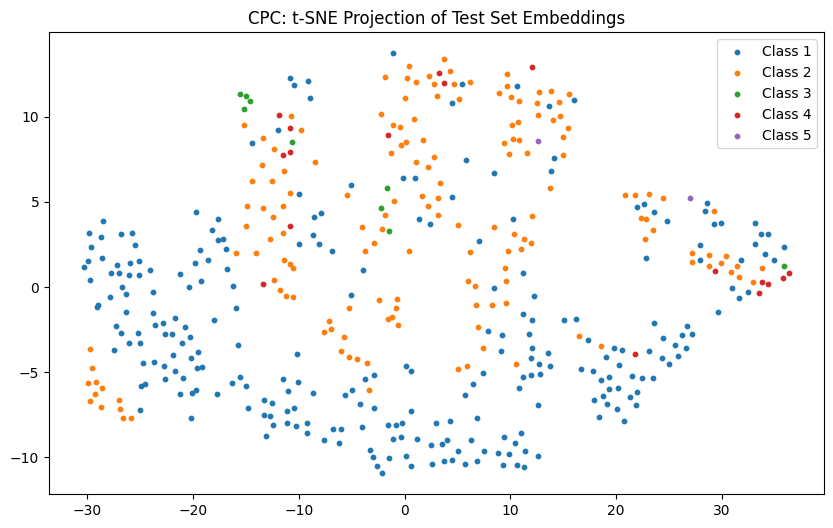

In [15]:
import seaborn as sns
palette = sns.color_palette("tab10", 5)

# Plot with corrected labels
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", 5)
for label in np.unique(labels_proj):
    idx = labels_proj == label
    plt.scatter(X_proj[idx, 0], X_proj[idx, 1], s=10, label=f'Class {label}', color=palette[label-1])
plt.title("CPC: t-SNE Projection of Test Set Embeddings")
plt.legend()
plt.show()